# Tf-idf

In [1]:
import re
import pathlib
import numpy as np

In [2]:
pathfile = r'E:\STUDY\8PM9I\UIRS'
dataset_file = pathlib.Path(pathfile).joinpath('temp')

In [3]:
class Patient:
    """
    In treatment_days each day is an element.
    vectorizer is TfidfVectorizer
    tfidf_scores contains dict of bags of words(bows) for an each day
    keybows conatins the highest num_keybows tfidf_scores 
    """
    num_keybows = 5
    
    def __init__(self):
        self.treatment_days = []
        self.vectorizer = None
        self.matrix = None
        self.tfidf_scores = []
        self.keybows = []
        self.num_days = []
    def __len__(self):
        return len(self.treatment_days)

In [4]:
docs = (file for file in dataset_file.iterdir() if file.suffix == '.txt')

date_pattern = re.compile(r'\d\d[.]\d\d[.]\d\d\d\d(.)')

patients = []
for patientfile in docs:
    with open(patientfile, 'rt') as pf: 
        patient = Patient()
        for i, day in enumerate(pf):
            day = re.sub(date_pattern, '', day)
            day = re.sub('\n', '', day)
            day = re.sub(r'[0-9]+', '', day)
            patient.treatment_days.append(day)
            patient.num_days.append(i+1)
    patients.append(patient)
patients

In [5]:
"""Заполнить незаолненные дни предыдущим днем (считаем, что состояние пациента не изменилось)"""
for patient in patients:
    for i, day in enumerate(patient.treatment_days):
        if day in [' ', '']:
            patient.treatment_days[i] = patient.treatment_days[i-1]
    
patients[0].treatment_days

['Жалобы: На распирающую боль, жжение, зуд в области левой голени, общее недомогание, слабость, разбитость, повышение температуры до ,. Локальный статус: на левой голени эритема с множеством геморрагий, границы, четкие, горячая на ощупь, отек мягких тканей умеренно выражен, тестоватой консистенции, болезненность по периферии преобладает.',
 'Жалобы: На умеренную боль ',
 'Жалобы: Чувствует себя лучше, температура нормальная, местные явления начали регрессировать, меньше отек и гиперемия. Локальный статус: На левой голени эритема, болезненность незначительная. Паховые лимфатические узлы слева слегка слегка болезненны.',
 'Локальный статус: Паховые лимфатические узлы слева слегка безболезненны.',
 'Жалобы: Местные явления существенно меньше. Локальный статус: На левой голени эритема стала значительно бледнее.',
 'Жалобы: Местные явления существенно меньше. Локальный статус: На левой голени эритема стала значительно бледнее.',
 'Локальный статус: На голени бледнеющая гиперемия, отцветающи

In [6]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

for patient in patients:
    for i, day in enumerate(patient.treatment_days):
        words = day.split()
        for word in words:    
            p = morph.parse(word.strip(':,-'))[0]
            day = day.replace(word.strip(':,-'), p.normal_form)
        patient.treatment_days[i] = day
patients[1].treatment_days

['жалоба: повышение температура до ,, слабость, головной боль, разбитость.',
 'жалоба: повышение температура до ,, слабость, головной боль, разбитость.',
 'жалоба: боль в правый нижний конечность, распирать характер, усиливаться в вертикальный положении.',
 'жалоба: боль в правый нижний конечность, распирать характер, усиливаться в вертикальный положении.',
 'жалоба: боль в правый нижний конечность, распирать характер, усиливаться в вертикальный положении.',
 'локальный статус: в область правый голень и коленный сустав иметься угасать эритема.',
 'локальный статус: в область правый голень и коленный сустав сохраняться угасать эритема, граница размытый, появиться небольшой шелушение кожи. участок флюктуация, размягчение нет.',
 'жалоба: не предъявлять локальный статус: в область правый голень и коленный сустав пигментация и шелушение кожи.',
 'жалоба: не предъявлять локальный статус: в область правый голень и коленный сустав пигментация и шелушение кожи.',
 'жалоба: не предъявлять локал

In [7]:
from nltk.corpus import stopwords


additional_stop_words = ['дата','время','осмотра','номер','пациента', 'локальный','статус','осмотр']
russian_stopwords = stopwords.words("russian")
russian_stopwords += additional_stop_words
#print(russian_stopwords)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer


for patient in patients:
    if patient.vectorizer is None:
        vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1, 3))
        matrix = vectorizer.fit_transform(patient.treatment_days)
        feature_names = vectorizer.get_feature_names()
        patient.vectorizer = vectorizer
        patient.matrix = matrix
        
        for iday in range(len(patient.treatment_days)):
            feature_index = matrix[iday,:].nonzero()[1]
            scores = zip(feature_index, [matrix[iday,x] for x in feature_index])
            tfidf = {}
            for word, value in [(feature_names[i], value) for (i, value) in scores]:
                tfidf[word] = value
            patient.tfidf_scores.append(tfidf)
        
    
    
patients[1].tfidf_scores

[{'жалоба': 0.1070961986806036,
  'повышение': 0.24447613932702925,
  'температура': 0.24447613932702925,
  'слабость': 0.24447613932702925,
  'головной': 0.24447613932702925,
  'боль': 0.17953573745686585,
  'разбитость': 0.24447613932702925,
  'жалоба повышение': 0.24447613932702925,
  'повышение температура': 0.24447613932702925,
  'температура слабость': 0.24447613932702925,
  'слабость головной': 0.24447613932702925,
  'головной боль': 0.24447613932702925,
  'боль разбитость': 0.24447613932702925,
  'жалоба повышение температура': 0.24447613932702925,
  'повышение температура слабость': 0.24447613932702925,
  'температура слабость головной': 0.24447613932702925,
  'слабость головной боль': 0.24447613932702925,
  'головной боль разбитость': 0.24447613932702925},
 {'жалоба': 0.1070961986806036,
  'повышение': 0.24447613932702925,
  'температура': 0.24447613932702925,
  'слабость': 0.24447613932702925,
  'головной': 0.24447613932702925,
  'боль': 0.17953573745686585,
  'разбитость': 

In [9]:
#bow - bag of words
num_keybows = Patient.num_keybows

for patient in patients:
    for iday in range(len(patient.treatment_days)):
        bows = patient.tfidf_scores[iday]
        sorted_ = sorted(bows, key=bows.get, reverse=True)[:num_keybows]
        tfidf = {}
        for keybow in sorted_:
            tfidf[keybow] = patient.tfidf_scores[iday][keybow]
        patient.keybows.append(tfidf)
    
patients[1].keybows[0]

{'повышение': 0.24447613932702925,
 'температура': 0.24447613932702925,
 'слабость': 0.24447613932702925,
 'головной': 0.24447613932702925,
 'разбитость': 0.24447613932702925}

In [10]:
from yellowbrick.text import FreqDistVisualizer
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

visualizer = FreqDistVisualizer(features=patients[1].vectorizer.get_feature_names())
visualizer.fit(patients[1].matrix)
visualizer.show()

<Figure size 800x800 with 1 Axes>

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}


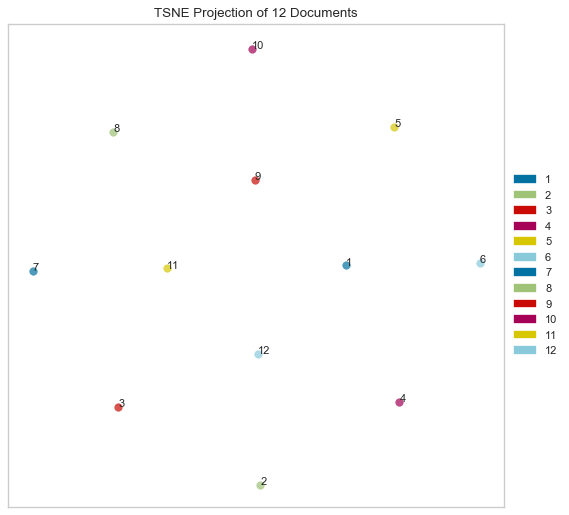

In [11]:
from yellowbrick.text import TSNEVisualizer
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

tsne = TSNEVisualizer(labels=patients[0].num_days)
tsne.fit(patients[0].matrix, patients[0].num_days)
tsne.poof()


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=10)
p = pca.fit_transform(patients[0].matrix.toarray())



for i in range(len(patients[0].num_days)):
    plt.annotate(i, xy=(p[i,0], p[i,1]))

In [184]:
import sys
sys.path

['',
 'c:\\users\\roman\\appdata\\local\\programs\\python\\python36\\python36.zip',
 'c:\\users\\roman\\appdata\\local\\programs\\python\\python36\\DLLs',
 'c:\\users\\roman\\appdata\\local\\programs\\python\\python36\\lib',
 'c:\\users\\roman\\appdata\\local\\programs\\python\\python36',
 'c:\\users\\roman\\appdata\\local\\programs\\python\\python36\\lib\\site-packages',
 'c:\\users\\roman\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Roman\\.ipython']

In [253]:
# import pandas as pd
# """Pandas dataframe"""

# df = pd.DataFrame(data=dataset[0].toarray())
# df.columns = vectorizers[0].get_feature_names()
# df.head()

c:\users\roman\appdata\local\programs\python\python36\lib\site-packages\sklearn\decomposition\pca.py:445: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
W1206 22:18:56.748055  8020 legend.py:1289] No handles with labels found to put in legend.


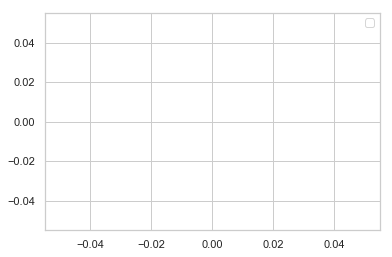

In [142]:
"""PCA in sklearn"""
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
X_pca = pca.fit_transform(df.head(1))
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
# plt.bar(range(1,df.shape[0]+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='индивидуальная объясненная дисперсия')
# plt.step(range(1,df.shape[0]+1), cum_var_exp, where='mid', label='кумулятивая объясненная дисперсия')
# plt.ylabel('доля объясненной дисперсии')
# plt.xlabel('главные компоненты')

plt.bar(10, pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.legend(loc='best')
plt.show()

12

In [ ]:
for da

(12, 10)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X  = df.iloc[:,:].values
X.shape

(11, 105)

numpy.ndarray

In [13]:
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
#eigen_vals

c:\users\roman\appdata\local\programs\python\python36\lib\site-packages\matplotlib\transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
c:\users\roman\appdata\local\programs\python\python36\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


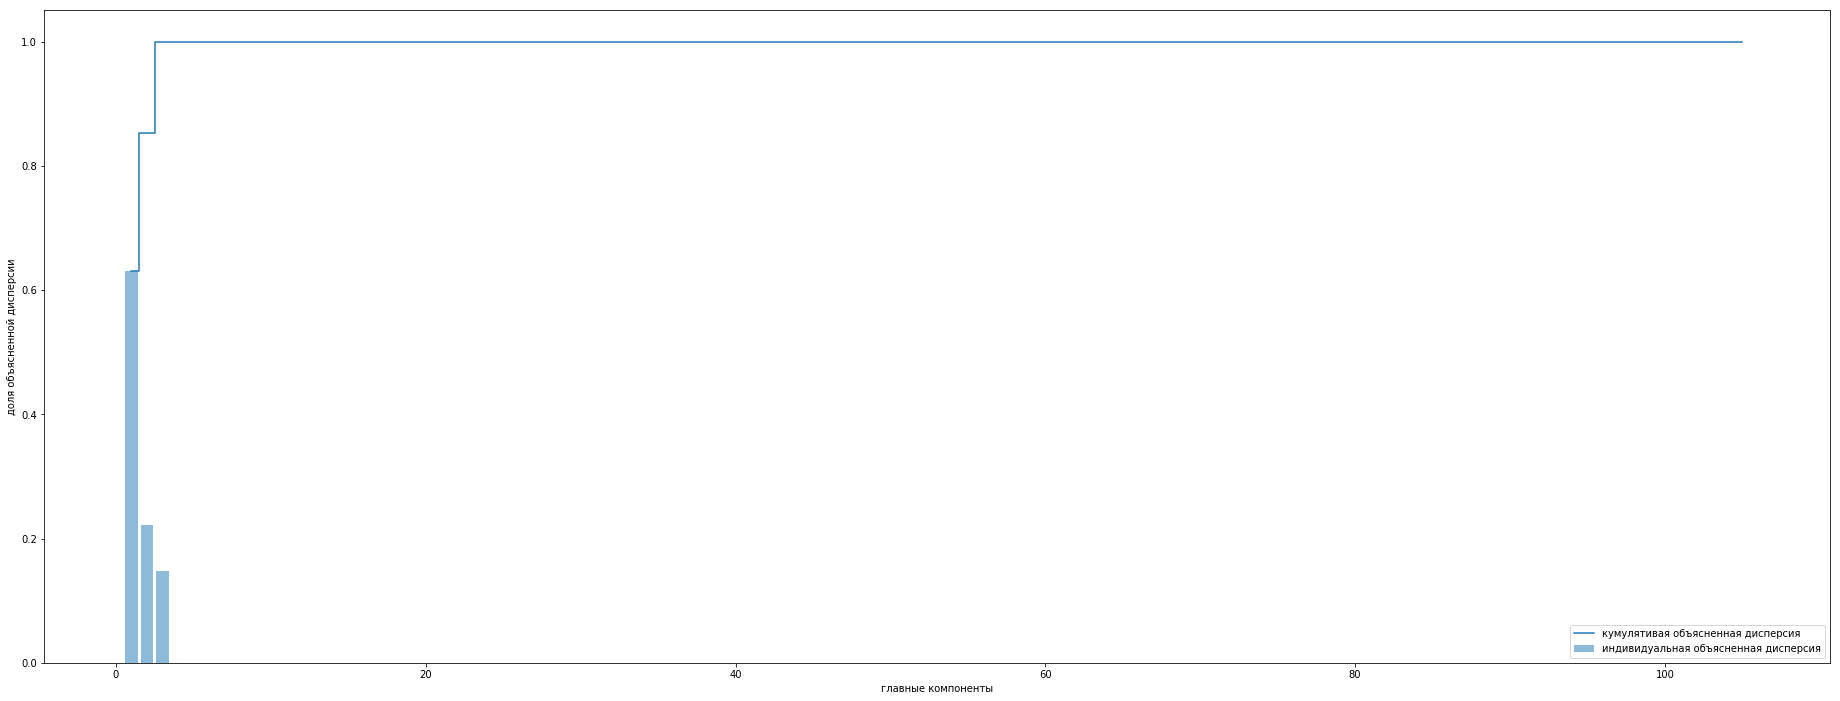

In [16]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
          sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(32,12))
plt.bar(range(1,X.shape[1]+1), var_exp, alpha=0.5, align='center', label='индивидуальная объясненная дисперсия')
plt.step(range(1,X.shape[1]+1), cum_var_exp, where='mid', label='кумулятивая объясненная дисперсия')
plt.ylabel('доля объясненной дисперсии')
plt.xlabel('главные компоненты')
plt.legend(loc='best')
plt.show()

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
X_pca = pca.fit_transform(X)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
cum_var_exp 

array([0.63018547, 0.85209853, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [18]:

# plt.bar(range(0,X.shape[0]), pca.explained_variance_ratio_, alpha=0.5, align='center', label='индивидуальная объясненная дисперсия')
# plt.step(range(0,X.shape[1]), cum_var_exp, where='mid', label='кумулятивая объясненная дисперсия')
# plt.ylabel('доля объясненной дисперсии')
# plt.xlabel('главные компоненты')
# plt.legend(loc='best')
# plt.show()

бисакод
бисакодила диурез
бисакодила диурез патолог
бол
боли слаб
боли слабость стул
волосист
волосистой част
волосистой части голов
выздоровлен
выписыва


IndexError: index 11 is out of bounds for axis 0 with size 11

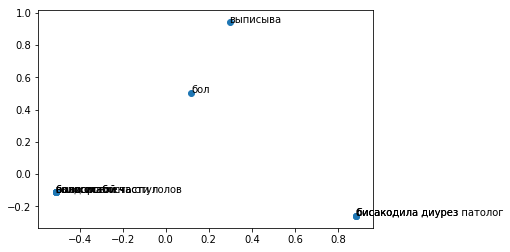

In [19]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(feature_names):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    print(word)
plt.show()

In [106]:
l = []
l.append({1:"sadas"})
type(l[0][1])

str